In [3]:
import os
import sys
import glob
import datetime
import cartopy
import warnings
import zipfile
import fnmatch
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from osgeo import ogr
from shapely.geometry import mapping

from ascat.cgls import SWI_TS
import pygeogrids
import pytesmo.timedate.dekad as dkd
import pytesmo.time_series.anomaly as tsa
import pytesmo.metrics as metrics
import pytesmo.scaling as scaling
import pytesmo.df_metrics as df_metrics
import pytesmo.temporal_matching as temp_match
import ftplib
warnings.filterwarnings('ignore')
data_path='./Data'
# read shapefiles of GTM 
name='GTM'

gad_1=os.path.join(data_path, 'gadm41_{:}_shp'.format(name), 'gadm41_{:}_1.shp'.format(name))
adm1_list = list(shpreader.Reader(gad_1).geometries())
gad_0=os.path.join(data_path, 'gadm41_{:}_shp'.format(name), 'gadm41_{:}_0.shp'.format(name))
adm0_list = list(shpreader.Reader(gad_0).geometries())

# plotting settings
sns.set(context='paper')
plot_crs = cartopy.crs.Mercator()
data_crs = cartopy.crs.PlateCarree()

# read time series CGLS, which are available as time series already stacked and updated half yearly
ts_io = SWI_TS(os.path.join(data_path, 'SWI_TS'))

# stack of CGLS data to attach NRT data to existing time series
filelist=glob.glob(os.path.join(data_path, 'CGLS','*', '*.nc'))
cgls_stack_slice = xr.open_mfdataset(filelist, engine='rasterio', chunks={}, combine='nested', 
                                     concat_dim='time').sortby('time').sel(x=slice(-95,-87),
                                                                           y=slice(19,12))  
swi_var=['SWI_001','SWI_020']
cgls=cgls_stack_slice[swi_var].compute()
cgls_lon_2d,cgls_lat_2d=np.meshgrid(cgls.x, cgls.y)
grid_cgls=pygeogrids.BasicGrid(cgls_lon_2d.flatten(),cgls_lat_2d.flatten())
cgls_lut=ts_io.grid.calc_lut(grid_cgls)


## stack of C3S data
# filelist=glob.glob(os.path.join(data_path, 'C3S', 'images','*.nc'))
# c3s_stack_slice = xr.open_mfdataset(filelist, engine='rasterio', chunks={}, combine='nested', 
#                               concat_dim='time').sortby('time').sel(x=slice(-95,-87),
#                                                                     y=slice(19,12))  
# c3s=c3s_stack_slice['sm'].compute()

# # create a look up table between the grid of CGLS and C3S for reading the same points
# c3s_lon_2d,c3s_lat_2d=np.meshgrid(c3s.x, c3s.y)
# grid_c3s=pygeogrids.BasicGrid(c3s_lon_2d.flatten(),c3s_lat_2d.flatten())
# lut=grid_cgls.calc_lut(grid_c3s, max_dist=25000)

# create a grid only covering GTM
drv = ogr.GetDriverByName("ESRI Shapefile")
ds_in = drv.Open(gad_0)
lyr_in = ds_in.GetLayer(0)
for feature in lyr_in:
    ply = feature.GetGeometryRef()
    grid=ts_io.grid.get_shp_grid_points(ply)

# create a dictionairy of districts with the CGLS gridpoints falling within that district
districts=[]
gpis=[]
ds_in = drv.Open(gad_1)
lyr_in = ds_in.GetLayer(0)
for feature in lyr_in:
    ply = feature.GetGeometryRef()    
    sgrid=ts_io.grid.get_shp_grid_points(ply)
    districts.append(feature.GetField('Name_1'))
    gpis.append(sgrid.activegpis)
gpi_dist = {districts[i]: gpis[i] for i in range(len(districts))}  

## Reading time series from stack of CGLS images
to read in time series from the CGLS stack we can use the selection method provided by xarray in combination with the time series reader ts_io. We concatenate the time series (cdr) with the image data (icdr) into one time series for the swi variables of choice. Here is is shown per grid point.  

Text(0, 0.5, 'SWI [% saturation]')

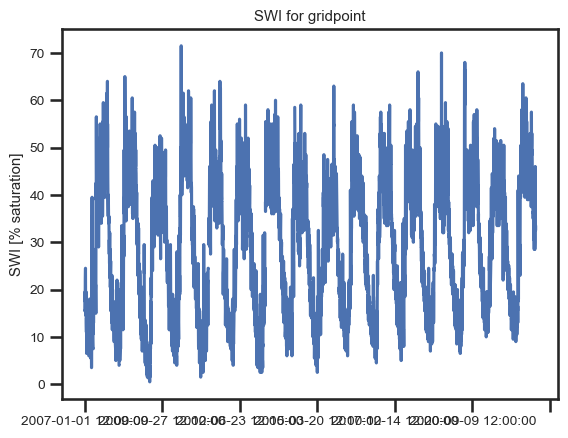

In [55]:
for gpi in grid.activegpis[0:1]:
    lon,lat=grid_cgls.arrlon[cgls_lut[gpi]],grid_cgls.arrlat[cgls_lut[gpi]]
    cdr = ts_io.read(gpi)
    icdr= cgls.sel(x=lon, y=lat).to_dataframe()
    df=pd.concat([cdr[swi_var], icdr[swi_var]])
    df[(df>100)|(df<0)] = np.NaN
ax=df['SWI_001'].plot(title='SWI for gridpoint')
ax.set_ylabel("SWI [% saturation]")

## District average SWI 
If we want to get the average SWI per district we need to merge different grid points into one. Using the dictionairy we created of district names and gridpoints we can easily do this. We get returned a dataframe with all the gridpoints in the district, and the district average. 

In [44]:
def district_ts(district):
    gpis=gpi_dist[district]
    dummy_dt=pd.date_range(datetime.datetime(2007,1,1),cgls.indexes['time'].to_datetimeindex()[-1])
    cgls_df=pd.DataFrame(index=dummy_dt, columns=pd.MultiIndex.from_product([['SWI_001','SWI_020'],gpis]))
    for gpi in gpis:
        lon,lat=grid_cgls.arrlon[cgls_lut[gpi]],grid_cgls.arrlat[cgls_lut[gpi]]
        cdr = ts_io.read(gpi)
        icdr= cgls.sel(x=lon, y=lat).to_dataframe()
        df=pd.concat([cdr[swi_var], icdr[swi_var]])
        df[(df>100)|(df<0)] = np.NaN
        cgls_df.loc[:,('SWI_001', gpi)]=df['SWI_001'].values
        cgls_df.loc[:,('SWI_020', gpi)]=df['SWI_020'].values

    cgls_df.loc[:,('SWI_001', district)] = cgls_df.xs('SWI_001',level=0, axis=1).median(axis=1)
    cgls_df.loc[:,('SWI_020', district)] = cgls_df.xs('SWI_020',level=0, axis=1).median(axis=1)
    return cgls_df
district='Alta Verapaz'
cgls_df=district_ts(district)


## Anomalies and absolute values plotting 
plotting the district average soil moisture absolute and anomalies can be done using the pytesmo package


(17897.0, 19357.0)

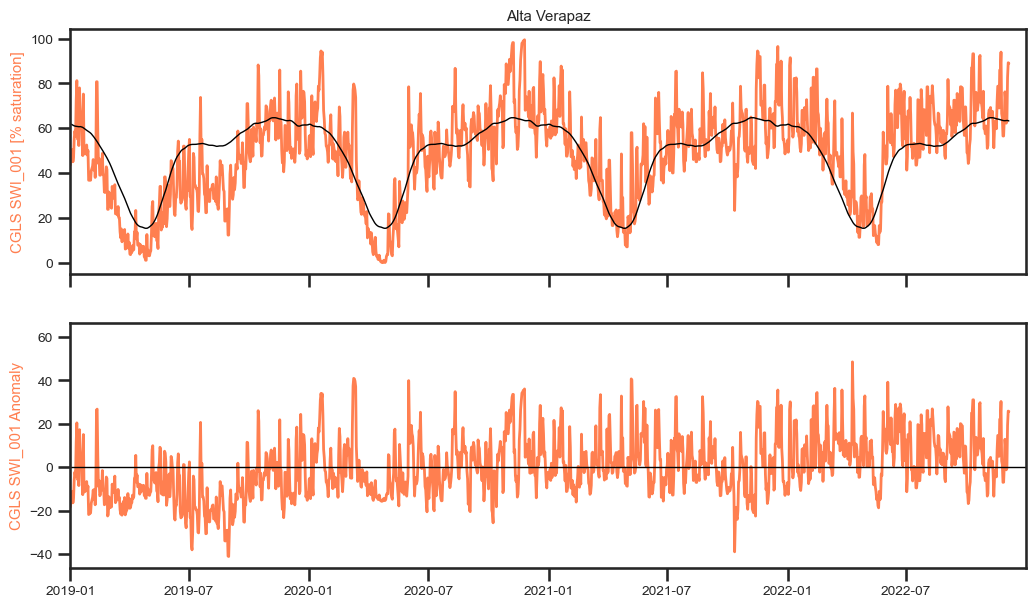

In [50]:
var='SWI_001'
sns.set(context='talk', style='ticks', font_scale=0.6)
clim = tsa.calc_climatology(cgls_df[var][district], respect_leap_years=True, wraparound=True)
anomaly = tsa.calc_anomaly(cgls_df[var][district], climatology=clim, respect_leap_years=True)                  
cgls_df.loc[:,(var, 'clim')] = clim[cgls_df.index.dayofyear].values
_, (ax1, ax2) = plt.subplots(2,1, figsize=(12.33, 7), sharex=True)
ax1.plot(cgls_df[var][district], c='coral', lw=2)
ax1.plot(cgls_df[var]['clim'], c='black', lw=1)
ax1.set_ylabel('CGLS {:} [% saturation]'.format(var), c='coral')
ax2.plot(anomaly, c='coral', lw=2)
ax2.set_ylabel('CGLS {:} Anomaly'.format(var), c='coral')
ax2.axhline(0,c='black', lw=1)
ax1.set_title(district)
ax1.set_xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2022, 12, 31)) 
